# Download video and save frames

In [0]:
!wget https://github.com/hsu-ai-course/hsu.ai/raw/master/code/datasets/ml/cut.mp4

--2020-05-12 21:06:42--  https://github.com/hsu-ai-course/hsu.ai/raw/master/code/datasets/ml/cut.mp4
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/hsu-ai-course/hsu.ai/master/code/datasets/ml/cut.mp4 [following]
--2020-05-12 21:06:43--  https://raw.githubusercontent.com/hsu-ai-course/hsu.ai/master/code/datasets/ml/cut.mp4
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2886393 (2.8M) [application/octet-stream]
Saving to: ‘cut.mp4’

cut.mp4             100%[===================>]   2.75M  13.2MB/s    in 0.2s    

2020-05-12 21:06:43 (13.2 MB/s) - ‘cut.mp4’ saved [2886393/2886393]



In [0]:
import numpy as np
import cv2

In [0]:
cap = cv2.VideoCapture("cut.mp4")
frame_count = cap.get(cv2.CAP_PROP_FRAME_COUNT)
fps = cap.get(cv2.CAP_PROP_FPS)
duration = float(frame_count) / float(fps)
video = []

ret = True
while(ret):
  ret, frame = cap.read()
  if ret:
    #frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    video.append(frame)
H, W, _ = video[0].shape
cap.release()

In [0]:
print(f"{W}x{H}, {duration:.2f} seconds, {fps:.3f} frames per second")

640x360, 30.03 seconds, 23.976 frames per second


# Segmentation Model
<h3><a href="https://cloud.google.com/tpu/"><img valign="middle" src="https://raw.githubusercontent.com/GoogleCloudPlatform/tensorflow-without-a-phd/master/tensorflow-rl-pong/images/tpu-hexagon.png" width="50"></a>  &nbsp;&nbsp;Use a free TPU device</h3>

   1. On the main menu, click Runtime and select **Change runtime type**. Set "TPU" as the hardware accelerator.
   1. Click Runtime again and select **Runtime > Run All**. You can also run the cells manually with Shift-ENTER.

## Import Libraries

In [1]:
import os
from io import BytesIO
import tarfile
import tempfile
from six.moves import urllib

from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image

%tensorflow_version 1.x
import tensorflow as tf

UsageError: Line magic function `%tensorflow_version` not found.


## Import helper methods
These methods help us perform the following tasks:
* Load the latest version of the pretrained DeepLab model
* Load the colormap from the PASCAL VOC dataset
* Adds colors to various labels, such as "pink" for people, "green" for bicycle and more
* Visualize an image, and add an overlay of colors on various regions

In [2]:
class DeepLabModel(object):
  """Class to load deeplab model and run inference."""

  INPUT_TENSOR_NAME = 'ImageTensor:0'
  OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
  INPUT_SIZE = 513
  FROZEN_GRAPH_NAME = 'frozen_inference_graph'

  def __init__(self, tarball_path):
    """Creates and loads pretrained deeplab model."""
    self.graph = tf.Graph()

    graph_def = None
    # Extract frozen graph from tar archive.
    tar_file = tarfile.open(tarball_path)
    for tar_info in tar_file.getmembers():
      if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
        file_handle = tar_file.extractfile(tar_info)
        graph_def = tf.GraphDef.FromString(file_handle.read())
        break

    tar_file.close()

    if graph_def is None:
      raise RuntimeError('Cannot find inference graph in tar archive.')

    with self.graph.as_default():
      tf.import_graph_def(graph_def, name='')

    self.sess = tf.Session(graph=self.graph)

  def run(self, image):
    """Runs inference on a single image.

    Args:
      image: A PIL.Image object, raw input image.

    Returns:
      resized_image: RGB image resized from original input image.
      seg_map: Segmentation map of `resized_image`.
    """
    width, height = image.size
    resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
    target_size = (int(resize_ratio * width), int(resize_ratio * height))
    resized_image = image.convert('RGB').resize(target_size, Image.ANTIALIAS)
    batch_seg_map = self.sess.run(
        self.OUTPUT_TENSOR_NAME,
        feed_dict={self.INPUT_TENSOR_NAME: [np.asarray(resized_image)]})
    seg_map = batch_seg_map[0]
    return resized_image, seg_map


def create_pascal_label_colormap():
  """Creates a label colormap used in PASCAL VOC segmentation benchmark.

  Returns:
    A Colormap for visualizing segmentation results.
  """
  colormap = np.zeros((256, 3), dtype=int)
  ind = np.arange(256, dtype=int)

  for shift in reversed(range(8)):
    for channel in range(3):
      colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

  return colormap


def label_to_color_image(label):
  """Adds color defined by the dataset colormap to the label.

  Args:
    label: A 2D array with integer type, storing the segmentation label.

  Returns:
    result: A 2D array with floating type. The element of the array
      is the color indexed by the corresponding element in the input label
      to the PASCAL color map.

  Raises:
    ValueError: If label is not of rank 2 or its value is larger than color
      map maximum entry.
  """
  if label.ndim != 2:
    raise ValueError('Expect 2-D input label')

  colormap = create_pascal_label_colormap()

  if np.max(label) >= len(colormap):
    raise ValueError('label value too large.')

  return colormap[label]


def vis_segmentation(image, seg_map):
  """Visualizes input image, segmentation map and overlay view."""
  plt.figure(figsize=(15, 5))
  grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1])

  plt.subplot(grid_spec[0])
  plt.imshow(image)
  plt.axis('off')
  plt.title('input image')

  plt.subplot(grid_spec[1])
  seg_image = label_to_color_image(seg_map).astype(np.uint8)
  plt.imshow(seg_image)
  plt.axis('off')
  plt.title('segmentation map')

  plt.subplot(grid_spec[2])
  plt.imshow(image)
  plt.imshow(seg_image, alpha=0.7)
  plt.axis('off')
  plt.title('segmentation overlay')

  unique_labels = np.unique(seg_map)
  ax = plt.subplot(grid_spec[3])
  plt.imshow(
      FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
  ax.yaxis.tick_right()
  plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
  plt.xticks([], [])
  ax.tick_params(width=0.0)
  plt.grid('off')
  plt.show()


LABEL_NAMES = np.asarray([
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
])

FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
FULL_COLOR_MAP = label_to_color_image(FULL_LABEL_MAP)

## Select a pretrained model
We have trained the DeepLab model using various backbone networks. Select one from the MODEL_NAME list.

In [0]:
MODEL_NAME = 'mobilenetv2_coco_voctrainaug'  # @param ['mobilenetv2_coco_voctrainaug', 'mobilenetv2_coco_voctrainval', 'xception_coco_voctrainaug', 'xception_coco_voctrainval']

_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'
_MODEL_URLS = {
    'mobilenetv2_coco_voctrainaug':
        'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
    'mobilenetv2_coco_voctrainval':
        'deeplabv3_mnv2_pascal_trainval_2018_01_29.tar.gz',
    'xception_coco_voctrainaug':
        'deeplabv3_pascal_train_aug_2018_01_04.tar.gz',
    'xception_coco_voctrainval':
        'deeplabv3_pascal_trainval_2018_01_04.tar.gz',
}
_TARBALL_NAME = 'deeplab_model.tar.gz'

model_dir = tempfile.mkdtemp()
tf.gfile.MakeDirs(model_dir)

download_path = os.path.join(model_dir, _TARBALL_NAME)
print('downloading model, this might take a while...')
urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + _MODEL_URLS[MODEL_NAME],
                   download_path)
print('download completed! loading DeepLab model...')

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

## Run on sample images

Select one of sample images (leave `IMAGE_URL` empty) or feed any internet image
url for inference.

Note that this colab uses single scale inference for fast computation,
so the results may slightly differ from the visualizations in the
[README](https://github.com/tensorflow/models/blob/master/research/deeplab/README.md) file,
which uses multi-scale and left-right flipped inputs.

In [0]:

SAMPLE_IMAGE = 'image1'  # @param ['image1', 'image2', 'image3']
IMAGE_URL = 'data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAkGBxMTEhUTExMWFhUXFxgYGBgYFRgXGBgYGBcWGBgaGBUaHSggGBolGxYYITEhJSkrLi4uGR8zODMsNygtLisBCgoKDg0OGxAQGy0mICYtLTUtLS8tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLf/AABEIALMBGQMBIgACEQEDEQH/xAAcAAACAwEBAQEAAAAAAAAAAAAEBQIDBgEABwj/xAA/EAACAQMDAgIIBAUDAgYDAAABAhEAAyEEEjEFQVFhBhMiMnGBkaGxwdHwBxQjQlJi4fGCohUkcrLC0kODkv/EABkBAAMBAQEAAAAAAAAAAAAAAAECAwQABf/EACsRAAICAgIBAwMCBwAAAAAAAAABAhEDIRIxQSJRYQQTMnHwFBUzgZGh4f/aAAwDAQACEQMRAD8A+c6cdpq9c8/QAmfmO1RFrzxJzGDFEWru3Pefj9qzyZfoJuXnAUhCIiJmIzjyrqXXJ9vG7xIH/A/Wu3LmJJJOcSIEmfPPkKIsuSBcYboPdoIHkBxU2MtlWnsknERkfU8edMzpthCbhHiRBEZPaRmfpXdPaQEEDBzDZJEd/n3otNSCQgAAU4gZXx4z/wAVByQXAt0+ktMVCsZ4iDOciD4z+NXdK0u0klixPMgzEdh2obQ6W6CXClgMD9TPFP7Nkkhjsnnjc36xQfsiiOaO4MlhuMwMRj95rQ6R1IP+P51nNOQ7kNJMnuAMeAFMVs3AZE7fyqdJPZzQ/GpkDb2OZNFWM5pTYeASfr5Ux01yV3Acink1QF0GG2CRPbijLaCl2kmZNHh4p4S8iysJVY5qxSKGVyRNEWE8a1wdvRGXyTqLmKtqtxVWhEyomTXN2amwHNUng1GToqtkHPzoMaaGnnHyHer1cwSBQusuQvJ8/OsuRpbLL2BLqHeGBAjv4zHb98UFrzcF2VkrA3djnHFRvh19sSQAPxxij21HdhkjxqFqiqdCwnaGYCYxPgfCe9L+o3mKjbubaAxPAMmILRzTe8N5jsM/6ZpZqXMbCO+I4jcMT48/Kg6Tsbl5AdSogccTzOe+DzWd6p08zODtEiMkCeAJwJz8jWnIBZoUEhRgnmQR86U3mBPtAEiMR4BgvPhP2qsJyW2N2JtHdALKwAaAO5BXxBn/ACPh3q8BNubm0DJBETyAdvnx5xRFyxbO1XPJk7VKgcY3djkj50Dp7AeWDEBQRJEiZaFJkTnyNKpKTtf8ItNAurkhismT3mT8J+NKkc5EHnmRH1/f2pxqLRUe8DBgkqQue0yT3nM/Klmo9lgB7zQVHskSx2yMZkQavjenRBsWagbX+M48/CqFtiCSP9jR7jaRvBDFfGO5HtceH4eNCNdGYAwM85gwc96unYjA7pIqv1lXXmHNVbvKqiDGxfxGwfHv5fCrdTbYxCxGDkmTI7njniuIZLBRHfnH7iuC7cJXsJB7CcRk/Cot7KWFaaJ29uIg5/M5g/KmNplC7ZEkxJUYnABOcd/GhXKSYM95EYmcVy3cMc+15D5+FQkzuhulrcPV43YIk4PPc/8AGaKS8tv2QN11p2wJjbg8H9xS3S3A4lpSMYyx4ABJwB8vnRd61bDSqiZmBJgyOe5OJqfFLRVLQWl64DDbkHz+mPrTbpesIgBSCRk+NL31IIyjg8+9uUiMZjHamvR9QvBWD5ZqbjqjlEmD7cYz3iMz/tTjQK5BMSVMQaC6fp7gIXB7Ekzz4edONHZKv8PpU6pjbOaoNt4jj/ijNJqDskGrbpRlIOPOh9LomUkHjse1XjvyDloKtXDRts4z2oHTzn8aMRe1On7isNsDFXhoFCrIq5TWzG9dEZItDYrk1yo1RuhUjrjFU3MV0vmK6xxUZO0OtA9w9qA1+nkc/pTF44oa6Jms00vJaLF125Cxz4+flVlwBlPBP3Aq+9bPB58aGa0FJmpSai9jWBbSuRH6Uj6qpLYIksBI/tkdgMcfjT/U31YkAwVOR2I+PhSy5q1EwoaMwBz8KyZJVN0G7K9XqVtjA4EDvnET40h183XlTLECTtjP4GjrmpLbQFksCdogkQe5xFUdRugSpEER5gjy4pocktjqVCrVW1U59kbPOSeOAaUXnZSqxySTmJwY8J7eHFNdeoLSCSTHiI8jigusWAyYVdwaTt7/ABkkgQYrVHj5JzKXuEj2YkycmDCjEk8ntk9/hSz1DMQ2z/pPPckzgbcH40WpUMMySBjmTwflx9zUr98AqVDAzt2zO6CpPn7vanxOnpE0gLW3g6A7JYiZMZHAPPh8uPjSG0kEiCfI9vM+FaK/ZUKpKkTMLjC+cGCR9cUuuxvKyJ5JEjbPGCOeJ5Na4SFkhdcORJn8qu2r41U6wwHlU4Pl9KdsmX2rwBMfXxonTaoQSRkYEd8j6mg9MCzEDkjw/cVbpkgtiYic584pJxTKoMKyRmBPz8PoAaLRNqMvbGSMz2Cx3jmqNNdAOVzgDwjvP0o31Nsjkq0jaQPZOeCOIrJK00jqYJpb8MYJKqMick/pTLQXSwwBkBv8jiIyfn+8kTpllmDkAc5xiPIGmNuyQAVtqs5ncS3OJM5z5V2X47KcfJZpjdDTkHsZ5HgfLFaBb8OGBEEe74HvQ+q0JIEOSYnj8CKXdNR1aI9rxNRfJ9nOx4usIJ2kxMmOxp/oL5fieJJ/WkdjX3BAITNOryuqjYRB58qVRV7FttjVNSoO0iSBmPxo+w/NI9NnM5FGWtWNwA5imUqehWthQfafKidNdDTB+NLLtwswPbvRdlAOJiqp7sYOZ4q+3PJoMMeDRun48a04tsnInurhNTbFUOkkGqy0KiT4zVLkngxVjntVSGKi3Yx5jVGrODFWNUCATE5qUvgZAZYHvB+f0qLtugmB8aIvWV3Dx4ofUWD9PEVNwbtj2jOavp23cR7Q3CPM/Ggb9pw6HALcAcAd5PetJqpUxEiMYB+xrIXmcOxj+o3E9gPDwnNQ4Oxk6K9ZcYsSntECGIJ+goLVAsoYnIgeYMggEU30+n3JMCTmQNsZ8D2xQ+ttoxAPjkxn5VSNdj8QS/bfaG3AFoMHkj8qru21YgSobvnHHl+lWa20oI2XJ7HGc+Zqu7ZQH2cQeIOO/NTlFnNGf6jc2odhM8gLiczBHPerbdg3pa5cUMYnMKO2Ao4j4V2/q2KuD7Uz54BOJmeD9ZqHTWtBNrrPgQc8904rXGTSon5BNyq8DaQCYABIIjg5xkcdoFCX9PNxjtVT/pBgRjuYHwpn1OxgOIVVYCQIiWHnzx27Gl1rLsLbZBgCI79o75nHnVU9WickBXE2tnOPzkfCuevavOSTJPl8656w+NUv3JhFpxODz4dhH+1FWkCsSvfmkyEhhOPGmun1CyRAIIPl96WUWuiiL004cye3FEm6EUEgYbg5H0+tBWxBEtAnAH2ox7IPGfpj681CWpIdBuqJKqyIFx7w9w/LtV/SL7pDMFaeZPAkfb9KGu6d4VeB4zA+JpZcusp94iPDvQ2+gts3Oq6/a2kI3bussMcdhS8aR3t71YjI55NC9P6pbcAssvnjKmY7HIpzpuooEImACJiMYqUpOMugcn4Gui6YpRTzAzng1y3qG9YVJgcUu1OqtwAlwyeYNE2LimDkmOe9LV9ipjrRPJIkRV2pO0SnNK+iqxBMGZNMHurhmBMH8KqsYQVtZdDZ+kVodLf3KCDmhdPcUknbznzqWmurviIj70bXg5uxvpl5J70UlCq48aMskEVoxtdEmed64TULoqm5cI7Zoye6CkWFjOKg1zMd6mgqFxJpP1CSPGaqdorjEgAVG+cUJVWjii/qEWCx5+2YoLW60EBSftAqF/TB2zxJj5RAPlNd1em/uMRHhxUKlQyKrUkzuMDsMd6o1AthgQuRJnv4xVKudvtEADzz8/pQ9+QQQZU+Bzx+OanKTSHsW6vXKrCEHtZYbTicSfKhusaUzujBUAEEzI71539Td9qPb4GcDyqes1RKEFTjz7UYNjQbM1qxt2wSF3Cc5+VMdXa2DCmWGBM/DnigOsam2xARuCOccVPS9UF1sthFgT/cc1SUZUv9hfYo1bsLZfghiPvHPerVCMsmFaMLI2mO8zM1RrNSSjWjEb5n4iaY9NdUQKFB8TGfGc1RxSQlKxeskhpkRB74g8Rx3HFKNICGeO3tTEiBnM+Yj61otYUEkLmJAjBjtFZ9APbloM7WGODzmM5g/KqwdIWSoirAkE9zOBFHfzNv/H/tFDKpAIwc4PfiI/KqNp8RRdMROit1gqfjRmyTEwI5qPqrcKWZts8L7xMe7nAP1ohoi2yyJwQfPz78+FPdoZErWj9pe/zq+45UEqc8YoPTXgrGVkVK7chCQOTzUmm2OqGes1TepDbs/rVOiQGC/EVSDNsmJAiaa6C5bIAYQImPypZaQ1bOaK5tb2cHtApvaQCQwy0c4H/Fe0IVk3CFI90RUtV6xlFx8gdhjArO/Y7jSssTSBjsUf8AUOPlT7T6UKFDc8TUug9RSEUgDcP3mo65m9bmQBjOfoa57WxZPwNdM20wBzR2nKMdpH/NJdOpVgTTa3cURVYOkSOavTECfD5YqQt5DVFtQGMHM0atiBQpBTLtNDYo0XkSELAE+6CQCT5DuaEtkDis5/ECUt27yidjEkGeMTnt2q2Jb0CrZrdOhyTUmuUp6B1F71okHcFGHPDrE89yOCfLxmo9b1ht29xO1SJ3iY4kCYkFjjA+5FU4vpAfYf6+ZghtpgweD4HwpX0f0k02rNwWLm5rTbXEEHkiRPKkg5GMGgfRy4w0r32AVmDPHgFUlZ+Rn518l9FeqtpdTZZYcwUugH3kIWY7AhhPyorHdnPTPvjP2OKX2eqWbyM1q4rhWKkqwYBhEiR3zWF/iL6UH1a2dO6st07bjhsqmQyAeJ4+E1b/AAl0R9RqIUKpvAgcSBat8RSfb9Nhs3Gny3yqrqDECDzRDKy/28/Wl+szJzx9Kk0PHsVG3nGc/WheqMRbO1SGJEEUVYvH1ZJBOSPnQuuue6GmCRz2qDiuQ2gU9IJAZyBcGZJmasuaR2tk7hjBx4U/1VpSo2ZI70n9JNUwtFVA394P7zSu26sdUYzqHTlWSB72c/vivWejwu4AHkZjvTC5busqkgTA97w+WeK5adANrMT2EKcYngnNU5NaO0uzN3k23JEEQMngGSIrrbt0njHHEVLqYdWXiG45Ex+XejQrxICyfnHznNUcumItsrbURkDcOJjx7UhbTklvZwc/KcY+E/Wndy+y+zsGM4PPypBqCm+42Tz+fh2p4W2CYUCJA/u8fEcD4MI+tS9S3+X/AGj9KhqFDrKjaY3Rxnj9yZoP13+k06QgZqrgEMoBBBlYxB7YiSZq7W3mZFaSZxDAN4cE5H40uvCEBJ+Ge1MEuTZMHcR2gtAEkgTwBI4olUjyXBJgD4Hir7llnt42qJzOIPMfOh0tzB5kD8IqvUlkBhlYPyAcjjkR+tLxVjJaDHGyzjkxu7fnkUVoroKLKzzJpbecm0DjtiZ7RRfS9YypHalnG0HyPtJaIQMufKhbfVbhV7Z92Ygjj4GnXQbi+pBYic4pQNKIc8jfyPCpRq3YWhgpKm2IjFHWA5YyDipvaV9hJwBg1fodSxkTPhNT5LsnMJLttFMrBBUePhS20rDDCQfxpV6XekR0KW4A9Zcbau6SAAMsY7CRjzq2OPN0TdVZrLWkPvfaj7LGINfHNL1zqNy1euJeJ9WVPvxvkSfZAHnIHhiea038P/Sy7e1D6a8S/wDT9YjECRtIVkJAG4e0CCRPM1eX0zjGyamro+jWknih/Sa238pe28hC0ESCFywI7yoNGaU1T6S6o29LddU3nbG3iQcEfSaXHFdjeRT0bX6lrqIq21tbYuI271oBB2OP7SCO2CM80T1/VXbW5XW22nFqAACbhP8Ac0e7sVeZ+1DdR9Iv/IXtTa9h3SbTMhIJgQG8O4zEUD0P0juf+Gre1ig3WZ0hbbKNrgqq7jO6Ykngd+K1xXyI5fAd6QXHXp1wloYaZpI7N6uceUzXwjp991ssUT1l13gkT7InxH9ze1EwIBz2r7j6b3p6fqBMFrRE+G4Rj618V6BrG3lUtyttWYCYLAZMtEbjkT4xUsTbsaRfrUdWuWLtsqQkhj/ltLAkxCjhZnlh8von8JJ/kd9wjLnaB3gKPa86wnW/SBnVbrWj/VB9h2DEhfZJMAQIUgYre/w5tbdKLQB9ltwnmHAMH4cfKny6VAjsX3fSu9p9bqRddn05uZTJNkQpVl8U2mSB8R57vRRcth1JZXXcrAHIIkEeVfP/AOJ/TQCLwSFYql1lkttCtEDgzAX6c0HpOvai5KC2q2tOm6yu4o+62CNrsG9vzHj86lwWSmhujS9S9IbekW5bZS14klLQwxB4Zp91JB9r86UdC6rf1GnZ75DE32VSigAKoQQviN27Jk1n+ta29rbunvOh9awFm6FDKhtyCSpOUhjBHw8a1/8ALLp9PatLgLA8ye5+JMn51LNFQjS7O2x/pdQEGxj2570o6tdtBlB9obu3NX3hviQYjDd4pD1Zz6wQZjt5eNZErlsqiv0k1ayVWQTABFLrDiJOSMCTyRXOoSbjQJxyRxPhQp1AVQI/fnT0xnfZT6R3IKHEnJ8Rx9qbaZh7YIG0EQYiZFZrr13Ibx70xTqRuIoAx3PjVHG4I6L2c1UNcI+QMwIwe/kKTXyVuMMcEfGQflTfU6aBJBNIdaIee2O9UxoXIjuiuAnIJMn5Y70y2eQ+ppZ1NfVuGE7Wj696h/4sPP70zhy2hE0tM7qUldxxgQO/PNF6dZtTjygZ58aCS0TM9h9zRb3gECg/EZ8PGP3NUfsOvcJ00lUg5MjNQ6heO3aWOOxM9okHsJ7fDwruhACHnv8AX4UDqtO4XdBAn9mprsZPQXv/AKYWCMYpx0JfZINJNLfDAKZMY+XxjFaDQRtgLHcRJJ7wTxxFJklWhovYz6NpiLbHHJrmmuj1LA8buaM0IKoQ2CRPyoG6yiyw/wBQqKfId9DbREMEWcEVb/LQ5A4FKekvLLJgCnSn2iRkUvFJiMPkxCn41jf4s2GfT2XUFtlwyQCYUoSxPgPZ5rTXgREGJqr0ge2mku+sPslCpHiXG0AeZJArRhdNUSyLR856Xq9lvSk6lre5ibqBiA1vfAJA972Txn4U8/hnoXPUrtwZtojqSCMBn/p98yEPH+NYqz0/1ltLkiQFEDvDHdP1+1bj+FnpLbt3Ltm4pHrbyKjATBjYiNGQCZg8STMTW3JfB0ZY9n2rTMIoP0sAOku7sAjyweZz4GKMsIBSr0h1yi5bsXPcvK2ZjIgEfMMPpWbHvTLib0euBunWUfIyue+9jOP+o1X6b3Ff+V05wGu7oHcAAQPk5pL1j0O1D3rSWbjfyyOHB37SstO0AD2o8T2Nad+gKl1L9+6zlFi2pMiTkk4kniPnVo30I6uy7086e1zSXEt/3ICPxj7V8F0ep/l7iPs3ldysCRmeeQQcjggg19g6/wCkTrZMiC90218lUA/7/Ovj3WG/qMQMFv2aWGpNDNemxxrL41JB2BFVNoUQBJMkgKAFHkB5kkmtf6JJettbJk22hD5HlSfKRH1rAdOeW2zyPuc/gK2fRes+r22pxIJ8ob8wAadu9AS1Zr/T+4U05YLu2shPzDD8SK+aI+oa4v8AVa273VF3CBTaO3g3BDNyYE95Bmvo/ppqQNHIhvWEZ5AUcfWfwrH9cdFFi4pIJhmgx7IEdu0n7VLG+LseS5RoYdAu3m/oMs7UYoRlhkld3hnbg8x5UTqOvK4W3clGVocFcz4we1X+henDtcCQCDLNOR2A+n0qr0+0frFF7umGgRIJ5+tTkuTtlOtGjXYbYMgwMHyrJ9aJLb+Nvh4VT0K4WtxvMAfTwoe9baH3sZ7Gs9eqg9im9q97MCQAR+FTsoGXtPalNt9xcngU79HtKrK08Y+NWlGkGPqVCXrWn9jzGfKh+lbgi+RrRekGjRNOxByY/GkPTFlIYwPGjF3AWUaeh4NYCm1uRWY6uQSCPCn9i37LDuBOaS9VtEKpjmux6YJW47C7r+t04G3tjxkf71l4PhT7RXCLQA86TzVYatE57pju5fUp7ICkj2p8R4QO/wCdBkEsABEDIFDWnk0zt2NoJLlCRMCT7OAJxzz9Kbo5MpDQIIMfScVFNQwXnHwkH41c2ncgAmRMDMgH8qG1TBJUfek09MoutnQxIMd/CmfRr7KrZ93jyNLNNIz28aPRmKMRx3pZ1VM6LS2POlaxmtsx5zUWun1JY92FCdKciy2Kpu6r+nH+qakqvQ/NUPOmgStH6bqEMyzGaWaC/wCyB3iaH0t0FyfOu4psa9GwbU7tvegfTAKNHckAyUCz/lvWCPOqLV4KV+H40r9PdUzaVgM7Cj/D2hP2NNjXqQmX8RJ0bpbquJG8tAz7Jjn4GKB6O/qGS5hWRt8NiXTOfPGPlV+i62d6BSvve0IMhgZ53cxOfOlOu1268wcDCkfMCfpgV6Nown6U6XrRdRLikFHVWUjwYAj8a9r7lo3rS3FDEq+2RIBEGB5xu+lZP+E2pZ+nWvFGuJ9LjEfZhTP0musLliPeUs489u2R813CskUosuvUNOr9Qtae2zsCEkTEYkgD4c0y6fq1dRK8jvBrP+l2mLaO6uDuU7ZBHswJJ8/A0w6aP6dthj2QzDyjBj/p+9aPJKtGT/iKVKXto9y/b7RBNvaY+lfNrtksAI8eB8e/x/A19JfRNe02pDYuXWZoPY8p+R+dYAqFQzyPZPbIMfrUX2y60gVLA3hVGAJPzEfrThLAS0zHJBH/ALT/AM0F0+wp9sfP9/Sr9bqQUEA7VA3TyC28D5dvpXLTQfDNP6NI97RWnLSuxlZTxh3zPIPaker6I7W9wYNsUxkztUmJEeFNfQLXRYa14FwsDjhjnx9omgLfUL4LAAwZYsZJCyJAmYpZ/kwwejTeiOmdbISycMZuOTBMwW+fPyNN/SXTA6W4D2HbyqXR9Wtq0DBnY7nEe6PzkVnbHW31HSjeaJdnU57G60AH/wBJFI4+mw3ugToGlG0EczmPCoekaFLkRgr9qu6GHCJsEST7R4+VC+mN+4WXfBx2rOk+RVdGet2tthzj2m+1WaXqJtDCyD4fCqmsstiGwDXtIkgiTgflVq7ArS0VarVs1p1IPjnt8K90KwHXafl5VXqr5a0YGMzmq+hOd4A8D3pq9LAntGn6jZRbbAcxzWX6ms2EY+MU11F92tOSMEH40mv3p04XMA9/ypMcWh8jT/wBWG/pt5D8aC9X5/epFsH4irMVp6MnZLR++Mc4yO3ypvqkIRhPvADmY4H4UP0rTDfnI7fgaN1NnZJIxPh2+PhmpTdsU7pbgFslR7uJOd2MT++1J9RYNw7gPaJ93x/9J8fI/KeK0FlJBKKY7juBPvR34NQ0ujZ3gKSCdwkqMHIkzAMDjmpqVO0g2KtFpz6sg4E9/gKPGgYAG2HZYG47cBvCRzTjp3eYLMYM5BAMZrmrs+qVpbcD/apxOcZHwqLy3KmK7oE02FZeZWTJAxOfxo7T9IR0DBTA5JBjJxn5GrbWjvW0Qe0VMtsVT7REHIEFsZnkcY5oy4NSUV2TYoJkIqhQQe/+HbsPnU5clfE5NlfS+nqzcgACD8ePxirOn9HtI+27xumZie0D51To7IbcE97kciM5PgTxRRdVKtO9l5J90ErwImYgx8aj9yfuMpSZo10Vj2toBiBk5z4DvSz0s0dkaW9O2CjRJAlgJUeOWAFCW9buZH94N7TCdu0yCZJjtIx3+tIvTvUgBE2lgBduDPsyluFAPiCxPbinwOU8iT/fkDkzC2r4sM0oGDrgxn9wfsPOp9Y1hN7cAoWFA2jn2VzPcian1WzKWAvf1kecFY+1K7IzBXdEjnAxA+UkfUV7pI+y/wAKL5Wzet7vZW7I8i6gt96d+k2vCXdKzEQbuzP+oR+dZf8Ah1qPV/zHj60EDvAtr+tbP0qs2n01tsEqwftySCZ+ED4RWD7bl9RL4KQlQ59MNYtrTqT3YIB47rb/AKT8qA9Ctat+27CfYRbfyC7h/wC81L+ICK1mxbYgEvuEnkqsf/Kh/wCHtpQNQoMnEx4ncPyrb5E8Afo2wvXtaZwuoAHgIRR/8a+YekgYX75/s9dcnyO4g/evrfoq1u1avvMC5cdnM99xg/LwrF9c6ZI1oPd/WD/9iB/xJHyrPKLjK/cvB3aMr0FXYsgGJk/OP0pzobSm3qyxkC0VMZyvtBo8mWu+gVoeq1F4+MD5KPzb7VT0zUi2LgOC3/2E/hQ7mUqoF3oX09rocZFp4IOQyuqnEfCjU6s1suLqAlVII/yhZgfENNNPRXqi3NW1tRtRbUsOweSufMz9qzXpAN2vvBWIAvqI8SAi00lcrFUklRsNZd/l9BeuXNxe6uxMloLTCgcKOcCsr0lmTpFpGmTfefkxx/21pv4na5bVi3ZE7nM45Cry3y+9ONa9r+U/lNo2sNoj+1ud31zNK1UKDuU9FPRtMDprWeBNYn0subtTtUmBArSaf1lu2F3CFwxn3YAPPzpBqOlt643eR7waZEfnNYMebe2CM+yHpygt6e0ByTnzwKE9FLCut3eeF/Woem124/q0j3R/tQvoyXXeCOR+HNXUn9q/J33PIw1PTba6Nn/uzSH0aszcHmD+Bp31TUn1NwRjaYrOdELK3h7MjzBpscm4NgU/Js7eiU6Rmke6ay96x/5IN/rijrt5wPV5Cn8DSrqOo2WfVDjdJ+OYoY27/uc81ideT5mmv/hreApWwiCaY/z7/wCNapX4J8qL+iuQc8U66kZTiaSF4INNtPrAVzUXvsmC+uIERkznw7CidBcZSVAI78/XFR1WogezzS+1qHnJyam/gNh166RKN7X+JjIJ8CPzpjaLL/ct0Ycg44Puz8aUE/Wr7V0dsVD9Q2G9PvXr9xm90knbk5x7vkBFVdP6cyMxIgMzcgHJiYkdtvPjULHUBaPsH2uBPFGnWtJOCfzNLJujl8jDRa9LZW26llIg7eTjx8BRPRNLafeGaVYmF8RxyODFIbdsesDnMGmPT1uKbiqPZO4qZ8c/jWbcafsMtjHVJZuKBaTZdtHawM7XEgye5nk/SrOqejB1SjcXBCtBYqqs7rcUwsTB3nJjtzmu2dTCLgG4Blu5P+rxqWpR721WuFYGZnJ8jVIZeMrS9vgFGDv9Je1ca1ctes2FtsHdBJDAd+YInwmu9J9FLwGobYzg22RRAkMXttETGApIg9u1bu5o7NtCQ2643vEncfhJ4HeKJ6PdcTt+U8Vp/jp/dUGgKB86foXUFuNstlGPq3VwwENC7c98wPCZp70vUXnsWkvNE6sWjBnc7OCViDK5InzEdq1+p1Fy44yfZwwHBkfbj71TaRbbJdlCLb71txDAyIYiI85znmatL671daBxL/4mrduGwLYO4pdhWx7pt/NZ4B+OKv8A4YJC3iAf/wAamTOQsnPeN8T5VT1jqq3X3MADgqJOSsEZ+OaqsdRNtyqHYG5jmTyR8pqf8wisnujuLEWv6gWR7Nj+26u8FinFySoaIBYA95NTbUG4LrjIulgIbdhSYBMchSBEdhjNPNLY0zC5bZZRhLsJlicZbvAEeQihV9GUsWm2sXViDJHtYA2yOJEcxT5PqJSXNIMZOPQj9HNM40QQA8sueZ3hSM8DepA8jQXo/wBI9ddtNcysOQN8TBgziWMjgeE8GtcWGzaT3wB2AntwCTBnPAoLT6pfWEI21lD4AwSwPI+JmsWX617j1fn2Gc20kc6dY9TqXvoqJbKup91SSpWXJnbtGw95M8YoGx0221/eYZiz3N4IK3FLMYjsV3IPOPKmrE7ULRCCRgSScHjxJ+1QFsW7apcaSxaM8EsSD9DFGGaSjUWAp9KtP/NahRnalpcxwyl2eAcsIiY7D4VJGuM9p7p2IWEQVzIOVQ5PPf40bpr6jeclnBE9lBgN+FCs+mKEEXPXhvZM7pOQCB2A8KL+plMdSa6I9R19the2hgu4ooPP9qZ++fI0m0vVWDwe42+QVA0Znuxioai+RIHhn4z+/tUOraJLBtEFn/vZpiQTChVOMQee1SxrnsXZd1LqA3EqASxlZHJIxz5ig01BG4Ee2YiBHx+M4z50FrNQWuIQMgzjmDM/T94oq09wksoPq1VgW7KcREZnFaVDyC9ntY4YFcmQQYIG095/ShLenKwTkbRIiIIESvgCAPI4rly+ltQCJBmPjBgyPM1TcvLBhjGPKcTxP+X4VbGqQeRbc1AADDIP775HNLNeu/8A/ok/ACKITUCIjJnz5gSew4NQuvECMGZ+XaaolT0LYruWWbJEAYFT2HxNGPcUiO+aq2LVeRxPdR6XVVc0ldjUw5IyaWePkJYxuXRBNDKTPNRsQcV31WaThR1h2mMnNW3rqztpcWIqAOZJzUpYbdhTGabQ3GaO0tuAfOliAGDTG0cCpSiMW2L5H60y0euhCPHvSm6PCqrzECBWdw5MNmk01g3EMGMduaFS24WCS5XGTJ+tLrXUGRfZwa5o9a+TOeaSeKo18h5Ggs6cTJBB8D2o7SkRhipPPB+xxSXRX3uzJoTUa17TwQT50sKUm1tnWaZ9QgRkJ/U1DSXS+GMYiYnjiaWDUI67jzTroxR1EVOfKbHTLdN0plIuMd3xqrXW0dmKYMfP5U317RbIrDrZ2XS25vrVLUFtAkjRdH3xtPu5wf3ir7/UCrbDxQGj1HgaHv8AtPzmhjzt6ElEYnSsCWkQRQmh6OASxMk17XapwAK707rCjDU0ocmLaBupXCjAnjEeVXC2t4DdMgYIqnrV222RVWh1AAxTxjTGQ5W0dkH4Hz+NLOqoyAMZJWIPf60ZaukZJqnq+pUpBoOVukPWhDcZrzFxAEzUdSgKgEkwoXnsPDwq/ToFXnmhb7Ko5qy06BWim8QtvGPxoBdayKVzDc0Pd1BnPFWXNQI4rWok2XlEYrgwB3M5qjXaZeRVX8z2FcNyTFOkKwfbAiZMzj7/AGoa7eP77URqHg4obUJImqJHFe+vetqnNeqlBCa6K5XqApfaFFLwK5XqR9nEblCHmvV6g+woYaXimKHFer1Y8nY5JWrneu16lRwu1zGalonPjXq9TPoRmk6YxFV+kOQCa9XqzQ/qDroWaRztOadej10g4Ndr1dk8hj2ay+xKZrGdWc7q9XqGT8UGQR0u4Y5qS3D6zmvV6pY1sVjbWGUz4Vn9Sor1erXk6E8gOpc+NXaNjAzXK9U4jIM1F9gOaC1l1iozXq9XR7HYGbpjmgjcJbmvV6tOPsDBNa2a8TivV6tXhCMiDXg1er1MAqvGq2OK9XqKAUGuV6vVQJ//2Q=='  #@param {type:"string"}

_SAMPLE_URL = ('https://github.com/tensorflow/models/blob/master/research/'
               'deeplab/g3doc/img/%s.jpg?raw=true')


def run_visualization(url):
  """Inferences DeepLab model and visualizes result."""
  try:
    f = urllib.request.urlopen(url)
    jpeg_str = f.read()
    original_im = Image.open(BytesIO(jpeg_str))
    print(original_im)
  except IOError:
    print('Cannot retrieve image. Please check url: ' + url)
    return

  print('running deeplab on image %s...' % url)
  resized_im, seg_map = MODEL.run(original_im)

  vis_segmentation(resized_im, seg_map)


image_url = IMAGE_URL or _SAMPLE_URL % SAMPLE_IMAGE
run_visualization(image_url)

In [0]:
%%time
# TPU
from tqdm import tqdm


predictions = []
for frame in tqdm(video):
  _, seg_map = MODEL.run(Image.fromarray(frame))
  labels, counts = np.unique(seg_map, return_counts=True)
  counts = counts / np.sum(counts)
  if len(labels) > 1 and counts[1] > 0.01:
    predictions.append((LABEL_NAMES[labels[1]], counts[1]))
  else:
    predictions.append(None)

  2%|▏         | 13/720 [01:50<1:38:08,  8.33s/it]

KeyboardInterrupt: ignored

  2%|▏         | 13/720 [01:58<1:47:30,  9.12s/it]


# Process predictions

In [0]:
def print_interval(i, l, last_time):
  def format_time(x):
    return f"{x / 24:.1f}"
  print(f"{format_time(last_i)}-{format_time(i)}: {l[0]}, \tconf: {l[1]:.3f}")


# print intervals with labels
last, last_i = None, 0
for i in range(len(video)):
  label = predictions[i]

  if not label or label[1] < 0.1:
    continue

  if not last:
    last = label[0]

  if last != label[0] or i == len(video) - 1:
    print_interval(i, label, last_i)
    last, last_i = label[0], i

('cow', 0.21275314056746805)


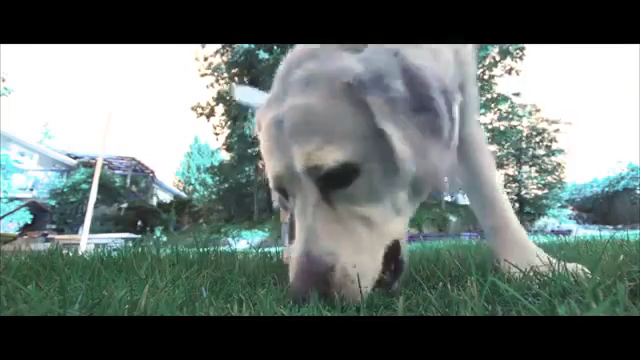

In [0]:
print(predictions[241])
Image.fromarray(video[241])